In [1]:
from rdkit import Chem
import sys
import os
import useful_rdkit_utils as uru
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
import itertools
import pandas as pd
from collections import Counter
import mols2grid
from tdc.single_pred import ADME
from Filtering_functions import filter_molecules
import glob
from rdkit.Chem import inchi
import molvs
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

In [2]:
# Get the current working directory
current_dir = os.getcwd()
print(current_dir)
# Get the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
print(parent_dir)
# Add the parent directory to sys.path
sys.path.append(parent_dir)

/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/Pocket2mol
/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model


Set the default image size

In [3]:
uru.rd_set_image_size(300,300)

### Reading the data from Pocket2mol

See if they are valid or not and also standardize them:

In [4]:
standardizer = molvs.standardize.Standardizer()

def standardize_mol(mol):
    try:
        mol = standardizer.standardize(mol)
        mol = standardizer.fragment_parent(mol, skip_standardize=True)
        mol = standardizer.tautomer_parent(mol, skip_standardize=True)
        mol = standardizer.isotope_parent(mol, skip_standardize=True)
        mol = standardizer.charge_parent(mol, skip_standardize=True)
        return mol
    except:
        return None

In [5]:
smi_list = []
with open('/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/Pocket2mol/combined_SMILES_100_pocket2mol.txt') as f:
    for smi in f:
        smi_list.append(smi.strip())
standardized_smiles_list = []
for smi in tqdm(smi_list, desc="Standardizing molecules", unit="mol"):
    mol = Chem.MolFromSmiles(smi)
    mol = standardize_mol(mol)
    if mol:
        standardized_smiles_list.append(Chem.MolToSmiles(mol))

print(len(smi_list))
len(standardized_smiles_list)

Standardizing molecules: 100%|██████████| 9707/9707 [28:39<00:00,  5.65mol/s]   

9707


9707

In [6]:
with open('combined_SMILES_100_pocket2mol_standardized.txt', 'w') as f:
    for item in standardized_smiles_list:
        f.write("%s\n" % item)

Convert SMILES and name of them to a dataframe

In [8]:
df = pd.DataFrame(standardized_smiles_list, columns=['SMILES'])
df

SMILES
0             CC(C)(O)CC(=O)O
1            CNC(=O)C(O)C(O)O
2              O=C(O)c1ccccc1
3                O=Cc1ccccc1O
4           CNC(=O)C(=O)C(O)O
...                       ...
9702     O=Cc1cccc(C(=O)O)c1O
9703    CC(=O)C(C=O)C(=O)NCCO
9704  Cn1[nH]c(=O)c2occc2c1=O
9705    Cc1ccc(C(=O)O)c(O)c1N
9706   O=C(O)C(=O)c1cccc(O)c1

[9707 rows x 1 columns]

Add an RDKit molecule to the dataframe

In [9]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

Strip salts from the molecule

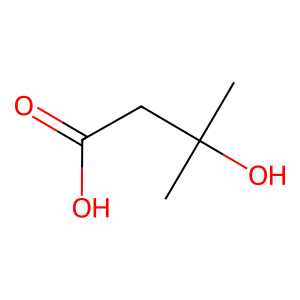

In [10]:
df.mol = df.mol.apply(uru.get_largest_fragment)
df.mol[0]

Instantiate a RingSystemFinder object and find ring systems for the molecules in df

In [11]:
ring_system_finder = uru.RingSystemFinder()
df['ring_sytems'] = df.mol.apply(ring_system_finder.find_ring_systems)
df.ring_sytems

0                                []
1                                []
2                        [c1ccccc1]
3                        [c1ccccc1]
4                                []
                   ...             
9702                     [c1ccccc1]
9703                             []
9704    [O=c1[nH][nH]c(=O)c2occc12]
9705                     [c1ccccc1]
9706                     [c1ccccc1]
Name: ring_sytems, Length: 9707, dtype: object

In [12]:
df.ring_sytems.values

array([list([]), list([]), list(['c1ccccc1']), ...,
       list(['O=c1[nH][nH]c(=O)c2occc12']), list(['c1ccccc1']),
       list(['c1ccccc1'])], dtype=object)

See how many times each ring system occurs

In [13]:
ring_system_list = list(itertools.chain.from_iterable(df.ring_sytems.values))
ring_count_df = pd.DataFrame(Counter(ring_system_list).items(),columns=["SMILES","Count"]) ### Convert a dictionary to a DataFrame.
ring_count_df.sort_values("Count",ascending=False,inplace=True)
ring_count_df

SMILES  Count
0                                         c1ccccc1   2615
5                                   c1ccc2ccccc2c1    338
7                                         c1ccncc1    271
4                                    O=c1cccc[nH]1    199
180                                 c1ccc2ncccc2c1    141
...                                            ...    ...
1707                        O=c1ccc2c([nH]1)NCCNC2      1
1708  O=C1NCCN2C(=O)CCNC(=O)N3CCNC(CC3)N3CCCC1=C23      1
1710                       O=C1C=C=C2CCCc3cccc1c32      1
1712                 O=C1N=Nc2c1ccc1ccc(=O)[nH]c21      1
1695                      O=C1CNC2=C(CNCN2)C(=O)N1      1

[4154 rows x 2 columns]

View the ring system frequencies

In [14]:
mols2grid.display(ring_count_df,subset=["img","Count"])

MolGridWidget()

The RingSystemLookup object has a dictionary of how many times each ring system occurs in the ChEMBL database.  We can use this object to evaluate the molecules in df.

In [15]:
ring_system_lookup = uru.RingSystemLookup()
res = df.mol.apply(ring_system_lookup.process_mol)

In [16]:
res

0                                     []
1                                     []
2                  [(c1ccccc1, 2568039)]
3                  [(c1ccccc1, 2568039)]
4                                     []
                      ...               
9702               [(c1ccccc1, 2568039)]
9703                                  []
9704    [(O=c1[nH][nH]c(=O)c2occc12, 0)]
9705               [(c1ccccc1, 2568039)]
9706               [(c1ccccc1, 2568039)]
Name: mol, Length: 9707, dtype: object

In [17]:
df[['min_ring','min_freq']] = res.apply(uru.get_min_ring_frequency).tolist()
df

SMILES  \
0             CC(C)(O)CC(=O)O   
1            CNC(=O)C(O)C(O)O   
2              O=C(O)c1ccccc1   
3                O=Cc1ccccc1O   
4           CNC(=O)C(=O)C(O)O   
...                       ...   
9702     O=Cc1cccc(C(=O)O)c1O   
9703    CC(=O)C(C=O)C(=O)NCCO   
9704  Cn1[nH]c(=O)c2occc2c1=O   
9705    Cc1ccc(C(=O)O)c(O)c1N   
9706   O=C(O)C(=O)c1cccc(O)c1   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x787d8450dfc0>   
1     <rdkit.Chem.rdchem.Mol object at 0x787d83c01070>   
2     <rdkit.Chem.rdchem.Mol object at 0x787d83c01230>   
3     <rdkit.Chem.rdchem.Mol object at 0x787d83c012a0>   
4     <rdkit.Chem.rdchem.Mol object at 0x787d83c01310>   
...                                                ...   
9702  <rdkit.Chem.rdchem.Mol object at 0x787d83b68ba0>   
9703  <rdkit.Chem.rdchem.Mol object at 0x787d83b68c10>   
9704  <rdkit.Chem.rdchem.Mol object at 0x787d83b68c80>   
9705  <rdkit.Chem.rdchem.Mol object at 0x787d83b68cf0>   
9706  <rdkit.Chem.rdchem.Mol object at 0x787d83b68d60>   

                      ring_sytems                   min_ring min_freq  
0                              []                                  -1  
1                              []                                  -1  
2                      [c1ccccc1]                   c1ccccc1  2568039  
3                      [c1ccccc1]                   c1ccccc1  2568039  
4                              []                                  -1  
...                           ...                        ...      ...  
9702                   [c1ccccc1]                   c1ccccc1  2568039  
9703                           []                                  -1  
9704  [O=c1[nH][nH]c(=O)c2occc12]  O=c1[nH][nH]c(=O)c2occc12        0  
9705                   [c1ccccc1]                   c1ccccc1  2568039  
9706                   [c1ccccc1]                   c1ccccc1  2568039  

[9707 rows x 5 columns]

In [18]:
df_ring_appearance_0 = df[df.min_freq == 0]
df_ring_appearance_0

SMILES  \
10          CC1=C=C(C)C(=O)NC1=O   
41         O=C1C(O)OC2CC(O)CC12O   
44    N=c1[nH]c(=N)c2ccncc2[nH]1   
57           CC12CCOC(=O)C1CCC2O   
64         CC12CCOC(=O)C1CC(O)C2   
...                          ...   
9584         O=C(O)C=C1OC(=O)CS1   
9683       O=C(O)c1cnc2c(c1)NCS2   
9691         Cn1c(O)c2ccoc2cc1=O   
9701  O=C(O)c1cnc2c(c1)=NC[SH]=2   
9704     Cn1[nH]c(=O)c2occc2c1=O   

                                                   mol  \
10    <rdkit.Chem.rdchem.Mol object at 0x787d83c015b0>   
41    <rdkit.Chem.rdchem.Mol object at 0x787d83c02340>   
44    <rdkit.Chem.rdchem.Mol object at 0x787d83c02490>   
57    <rdkit.Chem.rdchem.Mol object at 0x787d83c02a40>   
64    <rdkit.Chem.rdchem.Mol object at 0x787d83c02d50>   
...                                                ...   
9584  <rdkit.Chem.rdchem.Mol object at 0x787d83b65770>   
9683  <rdkit.Chem.rdchem.Mol object at 0x787d83b68350>   
9691  <rdkit.Chem.rdchem.Mol object at 0x787d83b686d0>   
9701  <rdkit.Chem.rdchem.Mol object at 0x787d83b68b30>   
9704  <rdkit.Chem.rdchem.Mol object at 0x787d83b68c80>   

                       ring_sytems                    min_ring min_freq  
10              [O=C1C=C=CC(=O)N1]            O=C1C=C=CC(=O)N1        0  
41                [O=C1COC2CCCC12]              O=C1COC2CCCC12        0  
44    [N=c1[nH]c(=N)c2ccncc2[nH]1]  N=c1[nH]c(=N)c2ccncc2[nH]1        0  
57               [O=C1OCCC2CCCC12]             O=C1OCCC2CCCC12        0  
64               [O=C1OCCC2CCCC12]             O=C1OCCC2CCCC12        0  
...                            ...                         ...      ...  
9584               [C=C1OC(=O)CS1]               C=C1OC(=O)CS1        0  
9683             [c1cnc2c(c1)NCS2]             c1cnc2c(c1)NCS2        0  
9691          [O=c1cc2occc2c[nH]1]          O=c1cc2occc2c[nH]1        0  
9701        [c1cnc2c(c1)=NC[SH]=2]        c1cnc2c(c1)=NC[SH]=2        0  
9704   [O=c1[nH][nH]c(=O)c2occc12]   O=c1[nH][nH]c(=O)c2occc12        0  

[4001 rows x 5 columns]

In [19]:
df_ring_appearance_0['SMILES'].to_csv('p2m_ring_appearance_0_100.smi',index=False,header=False)

In [20]:
df_ring_appearance_100more = df[df.min_freq > 100]
df_ring_appearance_100more

SMILES  \
2             O=C(O)c1ccccc1   
3               O=Cc1ccccc1O   
5            O=C(O)c1ccccc1O   
6          O=C(O)c1cccc(O)c1   
8            Nc1ccccc1C(=O)O   
...                      ...   
9699   CNC(=O)c1ccc(F)c(F)c1   
9700  O=C(O)c1ccc2[nH]cnc2c1   
9702    O=Cc1cccc(C(=O)O)c1O   
9705   Cc1ccc(C(=O)O)c(O)c1N   
9706  O=C(O)C(=O)c1cccc(O)c1   

                                                   mol         ring_sytems  \
2     <rdkit.Chem.rdchem.Mol object at 0x787d83c01230>          [c1ccccc1]   
3     <rdkit.Chem.rdchem.Mol object at 0x787d83c012a0>          [c1ccccc1]   
5     <rdkit.Chem.rdchem.Mol object at 0x787d83c01380>          [c1ccccc1]   
6     <rdkit.Chem.rdchem.Mol object at 0x787d83c013f0>          [c1ccccc1]   
8     <rdkit.Chem.rdchem.Mol object at 0x787d83c014d0>          [c1ccccc1]   
...                                                ...                 ...   
9699  <rdkit.Chem.rdchem.Mol object at 0x787d83b68a50>          [c1ccccc1]   
9700  <rdkit.Chem.rdchem.Mol object at 0x787d83b68ac0>  [c1ccc2[nH]cnc2c1]   
9702  <rdkit.Chem.rdchem.Mol object at 0x787d83b68ba0>          [c1ccccc1]   
9705  <rdkit.Chem.rdchem.Mol object at 0x787d83b68cf0>          [c1ccccc1]   
9706  <rdkit.Chem.rdchem.Mol object at 0x787d83b68d60>          [c1ccccc1]   

              min_ring min_freq  
2             c1ccccc1  2568039  
3             c1ccccc1  2568039  
5             c1ccccc1  2568039  
6             c1ccccc1  2568039  
8             c1ccccc1  2568039  
...                ...      ...  
9699          c1ccccc1  2568039  
9700  c1ccc2[nH]cnc2c1    49899  
9702          c1ccccc1  2568039  
9705          c1ccccc1  2568039  
9706          c1ccccc1  2568039  

[4151 rows x 5 columns]

In [21]:
df_ring_appearance_100more['SMILES'].to_csv('p2m_ring_appearance_100more_100.smi',index=False,header=False)

In [22]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

### Check how many molecules are unique the ring frequency of them

How many molecules are unique using inChI?

In [23]:
df['inchi'] = df.mol.apply(Chem.MolToInchi)
df = df.drop_duplicates("inchi", keep="first", ignore_index=True)
df

[13:59:23] WARNING: Omitted undefined stereo

[13:59:23] WARNING: Omitted undefined stereo

[13:59:23] WARNING: Omitted undefined stereo

[13:59:23] WARNING: Omitted undefined stereo

[13:59:23] WARNING: Omitted undefined stereo

[13:59:23] WARNING: Omitted undefined stereo

[13:59:23] WARNING: Omitted undefined stereo

[13:59:23] WARNING: Omitted undefined stereo

[13:59:23] WARNING: Omitted undefined stereo

[13:59:23] WARNING: Omitted undefined stereo

[13:59:23] WARNING: Omitted undefined stereo

[13:59:23] WARNING: Omitted undefined stereo

[13:59:23] WARNING: Omitted undefined stereo

[13:59:23] WARNING: Omitted undefined stereo

[13:59:23] WARNING: Omitted undefined stereo

[13:59:23] WARNING: Omitted undefined stereo

[13:59:23] WARNING: Omitted undefined stereo

[13:59:23] WARNING: Omitted undefined stereo

[13:59:23] WARNING: Omitted undefined stereo

[13:59:23] WARNING: Charges were rearranged; Omitted undefined stereo

[13:59:23] WARNING: Omitted undefined stereo

[13:59:23

SMILES  \
0             CC(C)(O)CC(=O)O   
1            CNC(=O)C(O)C(O)O   
2              O=C(O)c1ccccc1   
3                O=Cc1ccccc1O   
4           CNC(=O)C(=O)C(O)O   
...                       ...   
8759     O=Cc1cccc(C(=O)O)c1O   
8760    CC(=O)C(C=O)C(=O)NCCO   
8761  Cn1[nH]c(=O)c2occc2c1=O   
8762    Cc1ccc(C(=O)O)c(O)c1N   
8763   O=C(O)C(=O)c1cccc(O)c1   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x787d8450dfc0>   
1     <rdkit.Chem.rdchem.Mol object at 0x787d83c01070>   
2     <rdkit.Chem.rdchem.Mol object at 0x787d83c01230>   
3     <rdkit.Chem.rdchem.Mol object at 0x787d83c012a0>   
4     <rdkit.Chem.rdchem.Mol object at 0x787d83c01310>   
...                                                ...   
8759  <rdkit.Chem.rdchem.Mol object at 0x787d83b68ba0>   
8760  <rdkit.Chem.rdchem.Mol object at 0x787d83b68c10>   
8761  <rdkit.Chem.rdchem.Mol object at 0x787d83b68c80>   
8762  <rdkit.Chem.rdchem.Mol object at 0x787d83b68cf0>   
8763  <rdkit.Chem.rdchem.Mol object at 0x787d83b68d60>   

                      ring_sytems                   min_ring min_freq  \
0                              []                                  -1   
1                              []                                  -1   
2                      [c1ccccc1]                   c1ccccc1  2568039   
3                      [c1ccccc1]                   c1ccccc1  2568039   
4                              []                                  -1   
...                           ...                        ...      ...   
8759                   [c1ccccc1]                   c1ccccc1  2568039   
8760                           []                                  -1   
8761  [O=c1[nH][nH]c(=O)c2occc12]  O=c1[nH][nH]c(=O)c2occc12        0   
8762                   [c1ccccc1]                   c1ccccc1  2568039   
8763                   [c1ccccc1]                   c1ccccc1  2568039   

                                                  inchi  
0     InChI=1S/C5H10O3/c1-5(2,8)3-4(6)7/h8H,3H2,1-2H...  
1     InChI=1S/C4H9NO4/c1-5-3(7)2(6)4(8)9/h2,4,6,8-9...  
2     InChI=1S/C7H6O2/c8-7(9)6-4-2-1-3-5-6/h1-5H,(H,...  
3          InChI=1S/C7H6O2/c8-5-6-3-1-2-4-7(6)9/h1-5,9H  
4     InChI=1S/C4H7NO4/c1-5-3(7)2(6)4(8)9/h4,8-9H,1H...  
...                                                 ...  
8759  InChI=1S/C8H6O4/c9-4-5-2-1-3-6(7(5)10)8(11)12/...  
8760  InChI=1S/C7H11NO4/c1-5(11)6(4-10)7(12)8-2-3-9/...  
8761  InChI=1S/C7H6N2O3/c1-9-7(11)4-2-3-12-5(4)6(10)...  
8762  InChI=1S/C8H9NO3/c1-4-2-3-5(8(11)12)7(10)6(4)9...  
8763  InChI=1S/C8H6O4/c9-6-3-1-2-5(4-6)7(10)8(11)12/...  

[8764 rows x 6 columns]

How many molecules contains ring structure?

In [24]:
df_ring = df[df.min_freq != -1]
df_ring

SMILES  \
2                 O=C(O)c1ccccc1   
3                   O=Cc1ccccc1O   
5                O=C(O)c1ccccc1O   
6              O=C(O)c1cccc(O)c1   
8                Nc1ccccc1C(=O)O   
...                          ...   
8758  O=C(O)c1cnc2c(c1)=NC[SH]=2   
8759        O=Cc1cccc(C(=O)O)c1O   
8761     Cn1[nH]c(=O)c2occc2c1=O   
8762       Cc1ccc(C(=O)O)c(O)c1N   
8763      O=C(O)C(=O)c1cccc(O)c1   

                                                   mol  \
2     <rdkit.Chem.rdchem.Mol object at 0x787d83c01230>   
3     <rdkit.Chem.rdchem.Mol object at 0x787d83c012a0>   
5     <rdkit.Chem.rdchem.Mol object at 0x787d83c01380>   
6     <rdkit.Chem.rdchem.Mol object at 0x787d83c013f0>   
8     <rdkit.Chem.rdchem.Mol object at 0x787d83c014d0>   
...                                                ...   
8758  <rdkit.Chem.rdchem.Mol object at 0x787d83b68b30>   
8759  <rdkit.Chem.rdchem.Mol object at 0x787d83b68ba0>   
8761  <rdkit.Chem.rdchem.Mol object at 0x787d83b68c80>   
8762  <rdkit.Chem.rdchem.Mol object at 0x787d83b68cf0>   
8763  <rdkit.Chem.rdchem.Mol object at 0x787d83b68d60>   

                      ring_sytems                   min_ring min_freq  \
2                      [c1ccccc1]                   c1ccccc1  2568039   
3                      [c1ccccc1]                   c1ccccc1  2568039   
5                      [c1ccccc1]                   c1ccccc1  2568039   
6                      [c1ccccc1]                   c1ccccc1  2568039   
8                      [c1ccccc1]                   c1ccccc1  2568039   
...                           ...                        ...      ...   
8758       [c1cnc2c(c1)=NC[SH]=2]       c1cnc2c(c1)=NC[SH]=2        0   
8759                   [c1ccccc1]                   c1ccccc1  2568039   
8761  [O=c1[nH][nH]c(=O)c2occc12]  O=c1[nH][nH]c(=O)c2occc12        0   
8762                   [c1ccccc1]                   c1ccccc1  2568039   
8763                   [c1ccccc1]                   c1ccccc1  2568039   

                                                  inchi  
2     InChI=1S/C7H6O2/c8-7(9)6-4-2-1-3-5-6/h1-5H,(H,...  
3          InChI=1S/C7H6O2/c8-5-6-3-1-2-4-7(6)9/h1-5,9H  
5     InChI=1S/C7H6O3/c8-6-4-2-1-3-5(6)7(9)10/h1-4,8...  
6     InChI=1S/C7H6O3/c8-6-3-1-2-5(4-6)7(9)10/h1-4,8...  
8     InChI=1S/C7H7NO2/c8-6-4-2-1-3-5(6)7(9)10/h1-4H...  
...                                                 ...  
8758  InChI=1S/C7H5N2O2S/c10-7(11)4-1-5-6(8-2-4)12-3...  
8759  InChI=1S/C8H6O4/c9-4-5-2-1-3-6(7(5)10)8(11)12/...  
8761  InChI=1S/C7H6N2O3/c1-9-7(11)4-2-3-12-5(4)6(10)...  
8762  InChI=1S/C8H9NO3/c1-4-2-3-5(8(11)12)7(10)6(4)9...  
8763  InChI=1S/C8H6O4/c9-6-3-1-2-5(4-6)7(10)8(11)12/...  

[8446 rows x 6 columns]

In [25]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

SMILES  \
2             O=C(O)c1ccccc1   
3               O=Cc1ccccc1O   
5            O=C(O)c1ccccc1O   
6          O=C(O)c1cccc(O)c1   
8            Nc1ccccc1C(=O)O   
...                      ...   
8756     O=C(O)Cc1c(O)cccc1O   
8757   CNC(=O)c1ccc(F)c(F)c1   
8759    O=Cc1cccc(C(=O)O)c1O   
8762   Cc1ccc(C(=O)O)c(O)c1N   
8763  O=C(O)C(=O)c1cccc(O)c1   

                                                   mol ring_sytems  min_ring  \
2     <rdkit.Chem.rdchem.Mol object at 0x787d83c01230>  [c1ccccc1]  c1ccccc1   
3     <rdkit.Chem.rdchem.Mol object at 0x787d83c012a0>  [c1ccccc1]  c1ccccc1   
5     <rdkit.Chem.rdchem.Mol object at 0x787d83c01380>  [c1ccccc1]  c1ccccc1   
6     <rdkit.Chem.rdchem.Mol object at 0x787d83c013f0>  [c1ccccc1]  c1ccccc1   
8     <rdkit.Chem.rdchem.Mol object at 0x787d83c014d0>  [c1ccccc1]  c1ccccc1   
...                                                ...         ...       ...   
8756  <rdkit.Chem.rdchem.Mol object at 0x787d83b689e0>  [c1ccccc1]  c1ccccc1   
8757  <rdkit.Chem.rdchem.Mol object at 0x787d83b68a50>  [c1ccccc1]  c1ccccc1   
8759  <rdkit.Chem.rdchem.Mol object at 0x787d83b68ba0>  [c1ccccc1]  c1ccccc1   
8762  <rdkit.Chem.rdchem.Mol object at 0x787d83b68cf0>  [c1ccccc1]  c1ccccc1   
8763  <rdkit.Chem.rdchem.Mol object at 0x787d83b68d60>  [c1ccccc1]  c1ccccc1   

     min_freq                                              inchi  
2     2568039  InChI=1S/C7H6O2/c8-7(9)6-4-2-1-3-5-6/h1-5H,(H,...  
3     2568039       InChI=1S/C7H6O2/c8-5-6-3-1-2-4-7(6)9/h1-5,9H  
5     2568039  InChI=1S/C7H6O3/c8-6-4-2-1-3-5(6)7(9)10/h1-4,8...  
6     2568039  InChI=1S/C7H6O3/c8-6-3-1-2-5(4-6)7(9)10/h1-4,8...  
8     2568039  InChI=1S/C7H7NO2/c8-6-4-2-1-3-5(6)7(9)10/h1-4H...  
...       ...                                                ...  
8756  2568039  InChI=1S/C8H8O4/c9-6-2-1-3-7(10)5(6)4-8(11)12/...  
8757  2568039  InChI=1S/C8H7F2NO/c1-11-8(12)5-2-3-6(9)7(10)4-...  
8759  2568039  InChI=1S/C8H6O4/c9-4-5-2-1-3-6(7(5)10)8(11)12/...  
8762  2568039  InChI=1S/C8H9NO3/c1-4-2-3-5(8(11)12)7(10)6(4)9...  
8763  2568039  InChI=1S/C8H6O4/c9-6-3-1-2-5(4-6)7(10)8(11)12/...  

[3466 rows x 6 columns]

### How many of them could pass PAINS filter?

Get a list of rules

In [26]:
reos = uru.REOS()
reos.get_available_rule_sets()

array(['Glaxo', 'Dundee', 'BMS', 'PAINS', 'SureChEMBL', 'MLSMR',
       'Inpharmatica', 'LINT'], dtype=object)

Get the currently active rule sets

In [27]:
reos.get_active_rule_sets()

array(['Glaxo'], dtype=object)

Set active rule set to PAINS

In [28]:
reos.set_active_rule_sets(['PAINS'])
reos.get_active_rule_sets()

array(['PAINS'], dtype=object)

Apply PAINS filter to unique mols

In [29]:
reos.pandas_mols(df.mol)

  0%|          | 0/8764 [00:00<?, ?it/s]

rule_set_name description
0               ok          ok
1               ok          ok
2               ok          ok
3               ok          ok
4               ok          ok
...            ...         ...
8759            ok          ok
8760            ok          ok
8761            ok          ok
8762            ok          ok
8763            ok          ok

[8764 rows x 2 columns]

In [30]:
df_PAINS_filter = pd.concat([df, reos.pandas_mols(df.mol)], axis=1)
df_PAINS_filter = df_PAINS_filter[df_PAINS_filter.description == 'ok']
df_PAINS_filter

  0%|          | 0/8764 [00:00<?, ?it/s]

SMILES  \
0             CC(C)(O)CC(=O)O   
1            CNC(=O)C(O)C(O)O   
2              O=C(O)c1ccccc1   
3                O=Cc1ccccc1O   
4           CNC(=O)C(=O)C(O)O   
...                       ...   
8759     O=Cc1cccc(C(=O)O)c1O   
8760    CC(=O)C(C=O)C(=O)NCCO   
8761  Cn1[nH]c(=O)c2occc2c1=O   
8762    Cc1ccc(C(=O)O)c(O)c1N   
8763   O=C(O)C(=O)c1cccc(O)c1   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x787d8450dfc0>   
1     <rdkit.Chem.rdchem.Mol object at 0x787d83c01070>   
2     <rdkit.Chem.rdchem.Mol object at 0x787d83c01230>   
3     <rdkit.Chem.rdchem.Mol object at 0x787d83c012a0>   
4     <rdkit.Chem.rdchem.Mol object at 0x787d83c01310>   
...                                                ...   
8759  <rdkit.Chem.rdchem.Mol object at 0x787d83b68ba0>   
8760  <rdkit.Chem.rdchem.Mol object at 0x787d83b68c10>   
8761  <rdkit.Chem.rdchem.Mol object at 0x787d83b68c80>   
8762  <rdkit.Chem.rdchem.Mol object at 0x787d83b68cf0>   
8763  <rdkit.Chem.rdchem.Mol object at 0x787d83b68d60>   

                      ring_sytems                   min_ring min_freq  \
0                              []                                  -1   
1                              []                                  -1   
2                      [c1ccccc1]                   c1ccccc1  2568039   
3                      [c1ccccc1]                   c1ccccc1  2568039   
4                              []                                  -1   
...                           ...                        ...      ...   
8759                   [c1ccccc1]                   c1ccccc1  2568039   
8760                           []                                  -1   
8761  [O=c1[nH][nH]c(=O)c2occc12]  O=c1[nH][nH]c(=O)c2occc12        0   
8762                   [c1ccccc1]                   c1ccccc1  2568039   
8763                   [c1ccccc1]                   c1ccccc1  2568039   

                                                  inchi rule_set_name  \
0     InChI=1S/C5H10O3/c1-5(2,8)3-4(6)7/h8H,3H2,1-2H...            ok   
1     InChI=1S/C4H9NO4/c1-5-3(7)2(6)4(8)9/h2,4,6,8-9...            ok   
2     InChI=1S/C7H6O2/c8-7(9)6-4-2-1-3-5-6/h1-5H,(H,...            ok   
3          InChI=1S/C7H6O2/c8-5-6-3-1-2-4-7(6)9/h1-5,9H            ok   
4     InChI=1S/C4H7NO4/c1-5-3(7)2(6)4(8)9/h4,8-9H,1H...            ok   
...                                                 ...           ...   
8759  InChI=1S/C8H6O4/c9-4-5-2-1-3-6(7(5)10)8(11)12/...            ok   
8760  InChI=1S/C7H11NO4/c1-5(11)6(4-10)7(12)8-2-3-9/...            ok   
8761  InChI=1S/C7H6N2O3/c1-9-7(11)4-2-3-12-5(4)6(10)...            ok   
8762  InChI=1S/C8H9NO3/c1-4-2-3-5(8(11)12)7(10)6(4)9...            ok   
8763  InChI=1S/C8H6O4/c9-6-3-1-2-5(4-6)7(10)8(11)12/...            ok   

     description  
0             ok  
1             ok  
2             ok  
3             ok  
4             ok  
...          ...  
8759          ok  
8760          ok  
8761          ok  
8762          ok  
8763          ok  

[8135 rows x 8 columns]

Test all filters from rd filter

In [31]:
rd_filters = ['Glaxo', 'Dundee', 'BMS', 'SureChEMBL', 'MLSMR', 'Inpharmatica', 'LINT']
for filter in rd_filters:
    reos.set_active_rule_sets([filter])
    new_df = reos.pandas_mols(df.mol)
    print(filter, len(new_df[new_df.description == "ok"])/len(new_df), reos.get_active_rule_sets(), len(new_df[new_df.description == "ok"]))

  0%|          | 0/8764 [00:00<?, ?it/s]

Glaxo 0.9726152441807394 ['Glaxo'] 8524


  0%|          | 0/8764 [00:00<?, ?it/s]

Dundee 0.6597444089456869 ['Dundee'] 5782


  0%|          | 0/8764 [00:00<?, ?it/s]

BMS 0.8694659972615244 ['BMS'] 7620


  0%|          | 0/8764 [00:00<?, ?it/s]

SureChEMBL 0.8193747147421269 ['SureChEMBL'] 7181


  0%|          | 0/8764 [00:00<?, ?it/s]

MLSMR 0.6733226837060703 ['MLSMR'] 5901


  0%|          | 0/8764 [00:00<?, ?it/s]

Inpharmatica 0.7501141031492469 ['Inpharmatica'] 6574


  0%|          | 0/8764 [00:00<?, ?it/s]

LINT 0.7190780465540849 ['LINT'] 6302


### How many of them could pass filters suggested by Dr.Reymond?

In [32]:
df['Reymond'] = df.mol.apply(filter_molecules)
df

SMILES  \
0             CC(C)(O)CC(=O)O   
1            CNC(=O)C(O)C(O)O   
2              O=C(O)c1ccccc1   
3                O=Cc1ccccc1O   
4           CNC(=O)C(=O)C(O)O   
...                       ...   
8759     O=Cc1cccc(C(=O)O)c1O   
8760    CC(=O)C(C=O)C(=O)NCCO   
8761  Cn1[nH]c(=O)c2occc2c1=O   
8762    Cc1ccc(C(=O)O)c(O)c1N   
8763   O=C(O)C(=O)c1cccc(O)c1   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x787d8450dfc0>   
1     <rdkit.Chem.rdchem.Mol object at 0x787d83c01070>   
2     <rdkit.Chem.rdchem.Mol object at 0x787d83c01230>   
3     <rdkit.Chem.rdchem.Mol object at 0x787d83c012a0>   
4     <rdkit.Chem.rdchem.Mol object at 0x787d83c01310>   
...                                                ...   
8759  <rdkit.Chem.rdchem.Mol object at 0x787d83b68ba0>   
8760  <rdkit.Chem.rdchem.Mol object at 0x787d83b68c10>   
8761  <rdkit.Chem.rdchem.Mol object at 0x787d83b68c80>   
8762  <rdkit.Chem.rdchem.Mol object at 0x787d83b68cf0>   
8763  <rdkit.Chem.rdchem.Mol object at 0x787d83b68d60>   

                      ring_sytems                   min_ring min_freq  \
0                              []                                  -1   
1                              []                                  -1   
2                      [c1ccccc1]                   c1ccccc1  2568039   
3                      [c1ccccc1]                   c1ccccc1  2568039   
4                              []                                  -1   
...                           ...                        ...      ...   
8759                   [c1ccccc1]                   c1ccccc1  2568039   
8760                           []                                  -1   
8761  [O=c1[nH][nH]c(=O)c2occc12]  O=c1[nH][nH]c(=O)c2occc12        0   
8762                   [c1ccccc1]                   c1ccccc1  2568039   
8763                   [c1ccccc1]                   c1ccccc1  2568039   

                                                  inchi  Reymond  
0     InChI=1S/C5H10O3/c1-5(2,8)3-4(6)7/h8H,3H2,1-2H...     True  
1     InChI=1S/C4H9NO4/c1-5-3(7)2(6)4(8)9/h2,4,6,8-9...     True  
2     InChI=1S/C7H6O2/c8-7(9)6-4-2-1-3-5-6/h1-5H,(H,...     True  
3          InChI=1S/C7H6O2/c8-5-6-3-1-2-4-7(6)9/h1-5,9H     True  
4     InChI=1S/C4H7NO4/c1-5-3(7)2(6)4(8)9/h4,8-9H,1H...     True  
...                                                 ...      ...  
8759  InChI=1S/C8H6O4/c9-4-5-2-1-3-6(7(5)10)8(11)12/...     True  
8760  InChI=1S/C7H11NO4/c1-5(11)6(4-10)7(12)8-2-3-9/...     True  
8761  InChI=1S/C7H6N2O3/c1-9-7(11)4-2-3-12-5(4)6(10)...     True  
8762  InChI=1S/C8H9NO3/c1-4-2-3-5(8(11)12)7(10)6(4)9...     True  
8763  InChI=1S/C8H6O4/c9-6-3-1-2-5(4-6)7(10)8(11)12/...     True  

[8764 rows x 7 columns]

In [33]:
df_Reymond_filter = df[df.Reymond == True]
df_Reymond_filter

SMILES  \
0             CC(C)(O)CC(=O)O   
1            CNC(=O)C(O)C(O)O   
2              O=C(O)c1ccccc1   
3                O=Cc1ccccc1O   
4           CNC(=O)C(=O)C(O)O   
...                       ...   
8759     O=Cc1cccc(C(=O)O)c1O   
8760    CC(=O)C(C=O)C(=O)NCCO   
8761  Cn1[nH]c(=O)c2occc2c1=O   
8762    Cc1ccc(C(=O)O)c(O)c1N   
8763   O=C(O)C(=O)c1cccc(O)c1   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x787d8450dfc0>   
1     <rdkit.Chem.rdchem.Mol object at 0x787d83c01070>   
2     <rdkit.Chem.rdchem.Mol object at 0x787d83c01230>   
3     <rdkit.Chem.rdchem.Mol object at 0x787d83c012a0>   
4     <rdkit.Chem.rdchem.Mol object at 0x787d83c01310>   
...                                                ...   
8759  <rdkit.Chem.rdchem.Mol object at 0x787d83b68ba0>   
8760  <rdkit.Chem.rdchem.Mol object at 0x787d83b68c10>   
8761  <rdkit.Chem.rdchem.Mol object at 0x787d83b68c80>   
8762  <rdkit.Chem.rdchem.Mol object at 0x787d83b68cf0>   
8763  <rdkit.Chem.rdchem.Mol object at 0x787d83b68d60>   

                      ring_sytems                   min_ring min_freq  \
0                              []                                  -1   
1                              []                                  -1   
2                      [c1ccccc1]                   c1ccccc1  2568039   
3                      [c1ccccc1]                   c1ccccc1  2568039   
4                              []                                  -1   
...                           ...                        ...      ...   
8759                   [c1ccccc1]                   c1ccccc1  2568039   
8760                           []                                  -1   
8761  [O=c1[nH][nH]c(=O)c2occc12]  O=c1[nH][nH]c(=O)c2occc12        0   
8762                   [c1ccccc1]                   c1ccccc1  2568039   
8763                   [c1ccccc1]                   c1ccccc1  2568039   

                                                  inchi  Reymond  
0     InChI=1S/C5H10O3/c1-5(2,8)3-4(6)7/h8H,3H2,1-2H...     True  
1     InChI=1S/C4H9NO4/c1-5-3(7)2(6)4(8)9/h2,4,6,8-9...     True  
2     InChI=1S/C7H6O2/c8-7(9)6-4-2-1-3-5-6/h1-5H,(H,...     True  
3          InChI=1S/C7H6O2/c8-5-6-3-1-2-4-7(6)9/h1-5,9H     True  
4     InChI=1S/C4H7NO4/c1-5-3(7)2(6)4(8)9/h4,8-9H,1H...     True  
...                                                 ...      ...  
8759  InChI=1S/C8H6O4/c9-4-5-2-1-3-6(7(5)10)8(11)12/...     True  
8760  InChI=1S/C7H11NO4/c1-5(11)6(4-10)7(12)8-2-3-9/...     True  
8761  InChI=1S/C7H6N2O3/c1-9-7(11)4-2-3-12-5(4)6(10)...     True  
8762  InChI=1S/C8H9NO3/c1-4-2-3-5(8(11)12)7(10)6(4)9...     True  
8763  InChI=1S/C8H6O4/c9-6-3-1-2-5(4-6)7(10)8(11)12/...     True  

[8760 rows x 7 columns]

### How many of them could pass RO5?

In [34]:
def passes_rule_of_five(smiles):
    """Determine if a molecule passes Lipinski's Rule of Five."""
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        hbd = Descriptors.NumHDonors(mol)  # Hydrogen bond donors
        hba = Descriptors.NumHAcceptors(mol)  # Hydrogen bond acceptors
        mw = Descriptors.MolWt(mol)  # Molecular weight
        logp = Descriptors.MolLogP(mol)  # LogP
        
        # Check Lipinski's Rule of Five criteria
        if hbd <= 5 and hba <= 10 and mw <= 500 and logp <= 5:
            return True
    return False

df['Lipinski'] = df.SMILES.apply(passes_rule_of_five)
df

SMILES  \
0             CC(C)(O)CC(=O)O   
1            CNC(=O)C(O)C(O)O   
2              O=C(O)c1ccccc1   
3                O=Cc1ccccc1O   
4           CNC(=O)C(=O)C(O)O   
...                       ...   
8759     O=Cc1cccc(C(=O)O)c1O   
8760    CC(=O)C(C=O)C(=O)NCCO   
8761  Cn1[nH]c(=O)c2occc2c1=O   
8762    Cc1ccc(C(=O)O)c(O)c1N   
8763   O=C(O)C(=O)c1cccc(O)c1   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x787d8450dfc0>   
1     <rdkit.Chem.rdchem.Mol object at 0x787d83c01070>   
2     <rdkit.Chem.rdchem.Mol object at 0x787d83c01230>   
3     <rdkit.Chem.rdchem.Mol object at 0x787d83c012a0>   
4     <rdkit.Chem.rdchem.Mol object at 0x787d83c01310>   
...                                                ...   
8759  <rdkit.Chem.rdchem.Mol object at 0x787d83b68ba0>   
8760  <rdkit.Chem.rdchem.Mol object at 0x787d83b68c10>   
8761  <rdkit.Chem.rdchem.Mol object at 0x787d83b68c80>   
8762  <rdkit.Chem.rdchem.Mol object at 0x787d83b68cf0>   
8763  <rdkit.Chem.rdchem.Mol object at 0x787d83b68d60>   

                      ring_sytems                   min_ring min_freq  \
0                              []                                  -1   
1                              []                                  -1   
2                      [c1ccccc1]                   c1ccccc1  2568039   
3                      [c1ccccc1]                   c1ccccc1  2568039   
4                              []                                  -1   
...                           ...                        ...      ...   
8759                   [c1ccccc1]                   c1ccccc1  2568039   
8760                           []                                  -1   
8761  [O=c1[nH][nH]c(=O)c2occc12]  O=c1[nH][nH]c(=O)c2occc12        0   
8762                   [c1ccccc1]                   c1ccccc1  2568039   
8763                   [c1ccccc1]                   c1ccccc1  2568039   

                                                  inchi  Reymond  Lipinski  
0     InChI=1S/C5H10O3/c1-5(2,8)3-4(6)7/h8H,3H2,1-2H...     True      True  
1     InChI=1S/C4H9NO4/c1-5-3(7)2(6)4(8)9/h2,4,6,8-9...     True      True  
2     InChI=1S/C7H6O2/c8-7(9)6-4-2-1-3-5-6/h1-5H,(H,...     True      True  
3          InChI=1S/C7H6O2/c8-5-6-3-1-2-4-7(6)9/h1-5,9H     True      True  
4     InChI=1S/C4H7NO4/c1-5-3(7)2(6)4(8)9/h4,8-9H,1H...     True      True  
...                                                 ...      ...       ...  
8759  InChI=1S/C8H6O4/c9-4-5-2-1-3-6(7(5)10)8(11)12/...     True      True  
8760  InChI=1S/C7H11NO4/c1-5(11)6(4-10)7(12)8-2-3-9/...     True      True  
8761  InChI=1S/C7H6N2O3/c1-9-7(11)4-2-3-12-5(4)6(10)...     True      True  
8762  InChI=1S/C8H9NO3/c1-4-2-3-5(8(11)12)7(10)6(4)9...     True      True  
8763  InChI=1S/C8H6O4/c9-6-3-1-2-5(4-6)7(10)8(11)12/...     True      True  

[8764 rows x 8 columns]

In [35]:
df_Lipinski_filter = df[df.Lipinski == True]
df_Lipinski_filter

SMILES  \
0             CC(C)(O)CC(=O)O   
1            CNC(=O)C(O)C(O)O   
2              O=C(O)c1ccccc1   
3                O=Cc1ccccc1O   
4           CNC(=O)C(=O)C(O)O   
...                       ...   
8759     O=Cc1cccc(C(=O)O)c1O   
8760    CC(=O)C(C=O)C(=O)NCCO   
8761  Cn1[nH]c(=O)c2occc2c1=O   
8762    Cc1ccc(C(=O)O)c(O)c1N   
8763   O=C(O)C(=O)c1cccc(O)c1   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x787d8450dfc0>   
1     <rdkit.Chem.rdchem.Mol object at 0x787d83c01070>   
2     <rdkit.Chem.rdchem.Mol object at 0x787d83c01230>   
3     <rdkit.Chem.rdchem.Mol object at 0x787d83c012a0>   
4     <rdkit.Chem.rdchem.Mol object at 0x787d83c01310>   
...                                                ...   
8759  <rdkit.Chem.rdchem.Mol object at 0x787d83b68ba0>   
8760  <rdkit.Chem.rdchem.Mol object at 0x787d83b68c10>   
8761  <rdkit.Chem.rdchem.Mol object at 0x787d83b68c80>   
8762  <rdkit.Chem.rdchem.Mol object at 0x787d83b68cf0>   
8763  <rdkit.Chem.rdchem.Mol object at 0x787d83b68d60>   

                      ring_sytems                   min_ring min_freq  \
0                              []                                  -1   
1                              []                                  -1   
2                      [c1ccccc1]                   c1ccccc1  2568039   
3                      [c1ccccc1]                   c1ccccc1  2568039   
4                              []                                  -1   
...                           ...                        ...      ...   
8759                   [c1ccccc1]                   c1ccccc1  2568039   
8760                           []                                  -1   
8761  [O=c1[nH][nH]c(=O)c2occc12]  O=c1[nH][nH]c(=O)c2occc12        0   
8762                   [c1ccccc1]                   c1ccccc1  2568039   
8763                   [c1ccccc1]                   c1ccccc1  2568039   

                                                  inchi  Reymond  Lipinski  
0     InChI=1S/C5H10O3/c1-5(2,8)3-4(6)7/h8H,3H2,1-2H...     True      True  
1     InChI=1S/C4H9NO4/c1-5-3(7)2(6)4(8)9/h2,4,6,8-9...     True      True  
2     InChI=1S/C7H6O2/c8-7(9)6-4-2-1-3-5-6/h1-5H,(H,...     True      True  
3          InChI=1S/C7H6O2/c8-5-6-3-1-2-4-7(6)9/h1-5,9H     True      True  
4     InChI=1S/C4H7NO4/c1-5-3(7)2(6)4(8)9/h4,8-9H,1H...     True      True  
...                                                 ...      ...       ...  
8759  InChI=1S/C8H6O4/c9-4-5-2-1-3-6(7(5)10)8(11)12/...     True      True  
8760  InChI=1S/C7H11NO4/c1-5(11)6(4-10)7(12)8-2-3-9/...     True      True  
8761  InChI=1S/C7H6N2O3/c1-9-7(11)4-2-3-12-5(4)6(10)...     True      True  
8762  InChI=1S/C8H9NO3/c1-4-2-3-5(8(11)12)7(10)6(4)9...     True      True  
8763  InChI=1S/C8H6O4/c9-6-3-1-2-5(4-6)7(10)8(11)12/...     True      True  

[8024 rows x 8 columns]

### Molecules' performance in ring systems from ZINC22 database druglike molecules

In [45]:
ring_system_lookup_ZINC22 = uru.RingSystemLookup(ring_file="/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC22_rings_system.csv")
res_zinc22 = df.mol.apply(ring_system_lookup_ZINC22.process_mol)
res_zinc22

0                                     []
1                                     []
2              [(c1ccccc1, 21243538754)]
3              [(c1ccccc1, 21243538754)]
4                                     []
                      ...               
8759           [(c1ccccc1, 21243538754)]
8760                                  []
8761    [(O=c1[nH][nH]c(=O)c2occc12, 0)]
8762           [(c1ccccc1, 21243538754)]
8763           [(c1ccccc1, 21243538754)]
Name: mol, Length: 8764, dtype: object

In [46]:
df[['min_ring','min_freq']] = res_zinc22.apply(uru.get_min_ring_frequency).tolist()
df

SMILES  \
0             CC(C)(O)CC(=O)O   
1            CNC(=O)C(O)C(O)O   
2              O=C(O)c1ccccc1   
3                O=Cc1ccccc1O   
4           CNC(=O)C(=O)C(O)O   
...                       ...   
8759     O=Cc1cccc(C(=O)O)c1O   
8760    CC(=O)C(C=O)C(=O)NCCO   
8761  Cn1[nH]c(=O)c2occc2c1=O   
8762    Cc1ccc(C(=O)O)c(O)c1N   
8763   O=C(O)C(=O)c1cccc(O)c1   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x787d8450dfc0>   
1     <rdkit.Chem.rdchem.Mol object at 0x787d83c01070>   
2     <rdkit.Chem.rdchem.Mol object at 0x787d83c01230>   
3     <rdkit.Chem.rdchem.Mol object at 0x787d83c012a0>   
4     <rdkit.Chem.rdchem.Mol object at 0x787d83c01310>   
...                                                ...   
8759  <rdkit.Chem.rdchem.Mol object at 0x787d83b68ba0>   
8760  <rdkit.Chem.rdchem.Mol object at 0x787d83b68c10>   
8761  <rdkit.Chem.rdchem.Mol object at 0x787d83b68c80>   
8762  <rdkit.Chem.rdchem.Mol object at 0x787d83b68cf0>   
8763  <rdkit.Chem.rdchem.Mol object at 0x787d83b68d60>   

                      ring_sytems                   min_ring     min_freq  \
0                              []                                      -1   
1                              []                                      -1   
2                      [c1ccccc1]                   c1ccccc1  21243538754   
3                      [c1ccccc1]                   c1ccccc1  21243538754   
4                              []                                      -1   
...                           ...                        ...          ...   
8759                   [c1ccccc1]                   c1ccccc1  21243538754   
8760                           []                                      -1   
8761  [O=c1[nH][nH]c(=O)c2occc12]  O=c1[nH][nH]c(=O)c2occc12            0   
8762                   [c1ccccc1]                   c1ccccc1  21243538754   
8763                   [c1ccccc1]                   c1ccccc1  21243538754   

                                                  inchi  Reymond  Lipinski  
0     InChI=1S/C5H10O3/c1-5(2,8)3-4(6)7/h8H,3H2,1-2H...     True      True  
1     InChI=1S/C4H9NO4/c1-5-3(7)2(6)4(8)9/h2,4,6,8-9...     True      True  
2     InChI=1S/C7H6O2/c8-7(9)6-4-2-1-3-5-6/h1-5H,(H,...     True      True  
3          InChI=1S/C7H6O2/c8-5-6-3-1-2-4-7(6)9/h1-5,9H     True      True  
4     InChI=1S/C4H7NO4/c1-5-3(7)2(6)4(8)9/h4,8-9H,1H...     True      True  
...                                                 ...      ...       ...  
8759  InChI=1S/C8H6O4/c9-4-5-2-1-3-6(7(5)10)8(11)12/...     True      True  
8760  InChI=1S/C7H11NO4/c1-5(11)6(4-10)7(12)8-2-3-9/...     True      True  
8761  InChI=1S/C7H6N2O3/c1-9-7(11)4-2-3-12-5(4)6(10)...     True      True  
8762  InChI=1S/C8H9NO3/c1-4-2-3-5(8(11)12)7(10)6(4)9...     True      True  
8763  InChI=1S/C8H6O4/c9-6-3-1-2-5(4-6)7(10)8(11)12/...     True      True  

[8764 rows x 8 columns]

In [47]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [48]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

SMILES  \
2             O=C(O)c1ccccc1   
3               O=Cc1ccccc1O   
5            O=C(O)c1ccccc1O   
6          O=C(O)c1cccc(O)c1   
8            Nc1ccccc1C(=O)O   
...                      ...   
8756     O=C(O)Cc1c(O)cccc1O   
8757   CNC(=O)c1ccc(F)c(F)c1   
8759    O=Cc1cccc(C(=O)O)c1O   
8762   Cc1ccc(C(=O)O)c(O)c1N   
8763  O=C(O)C(=O)c1cccc(O)c1   

                                                   mol ring_sytems  min_ring  \
2     <rdkit.Chem.rdchem.Mol object at 0x787d83c01230>  [c1ccccc1]  c1ccccc1   
3     <rdkit.Chem.rdchem.Mol object at 0x787d83c012a0>  [c1ccccc1]  c1ccccc1   
5     <rdkit.Chem.rdchem.Mol object at 0x787d83c01380>  [c1ccccc1]  c1ccccc1   
6     <rdkit.Chem.rdchem.Mol object at 0x787d83c013f0>  [c1ccccc1]  c1ccccc1   
8     <rdkit.Chem.rdchem.Mol object at 0x787d83c014d0>  [c1ccccc1]  c1ccccc1   
...                                                ...         ...       ...   
8756  <rdkit.Chem.rdchem.Mol object at 0x787d83b689e0>  [c1ccccc1]  c1ccccc1   
8757  <rdkit.Chem.rdchem.Mol object at 0x787d83b68a50>  [c1ccccc1]  c1ccccc1   
8759  <rdkit.Chem.rdchem.Mol object at 0x787d83b68ba0>  [c1ccccc1]  c1ccccc1   
8762  <rdkit.Chem.rdchem.Mol object at 0x787d83b68cf0>  [c1ccccc1]  c1ccccc1   
8763  <rdkit.Chem.rdchem.Mol object at 0x787d83b68d60>  [c1ccccc1]  c1ccccc1   

         min_freq                                              inchi  Reymond  \
2     21243538754  InChI=1S/C7H6O2/c8-7(9)6-4-2-1-3-5-6/h1-5H,(H,...     True   
3     21243538754       InChI=1S/C7H6O2/c8-5-6-3-1-2-4-7(6)9/h1-5,9H     True   
5     21243538754  InChI=1S/C7H6O3/c8-6-4-2-1-3-5(6)7(9)10/h1-4,8...     True   
6     21243538754  InChI=1S/C7H6O3/c8-6-3-1-2-5(4-6)7(9)10/h1-4,8...     True   
8     21243538754  InChI=1S/C7H7NO2/c8-6-4-2-1-3-5(6)7(9)10/h1-4H...     True   
...           ...                                                ...      ...   
8756  21243538754  InChI=1S/C8H8O4/c9-6-2-1-3-7(10)5(6)4-8(11)12/...     True   
8757  21243538754  InChI=1S/C8H7F2NO/c1-11-8(12)5-2-3-6(9)7(10)4-...     True   
8759  21243538754  InChI=1S/C8H6O4/c9-4-5-2-1-3-6(7(5)10)8(11)12/...     True   
8762  21243538754  InChI=1S/C8H9NO3/c1-4-2-3-5(8(11)12)7(10)6(4)9...     True   
8763  21243538754  InChI=1S/C8H6O4/c9-6-3-1-2-5(4-6)7(10)8(11)12/...     True   

      Lipinski  
2         True  
3         True  
5         True  
6         True  
8         True  
...        ...  
8756      True  
8757      True  
8759      True  
8762      True  
8763      True  

[4063 rows x 8 columns]

In [49]:
filtered_df_ring_freq = df[(df.min_freq > 0) & (df.min_freq != -1)]
filtered_df_ring_freq

SMILES  \
2             O=C(O)c1ccccc1   
3               O=Cc1ccccc1O   
5            O=C(O)c1ccccc1O   
6          O=C(O)c1cccc(O)c1   
8            Nc1ccccc1C(=O)O   
...                      ...   
8756     O=C(O)Cc1c(O)cccc1O   
8757   CNC(=O)c1ccc(F)c(F)c1   
8759    O=Cc1cccc(C(=O)O)c1O   
8762   Cc1ccc(C(=O)O)c(O)c1N   
8763  O=C(O)C(=O)c1cccc(O)c1   

                                                   mol ring_sytems  min_ring  \
2     <rdkit.Chem.rdchem.Mol object at 0x787d83c01230>  [c1ccccc1]  c1ccccc1   
3     <rdkit.Chem.rdchem.Mol object at 0x787d83c012a0>  [c1ccccc1]  c1ccccc1   
5     <rdkit.Chem.rdchem.Mol object at 0x787d83c01380>  [c1ccccc1]  c1ccccc1   
6     <rdkit.Chem.rdchem.Mol object at 0x787d83c013f0>  [c1ccccc1]  c1ccccc1   
8     <rdkit.Chem.rdchem.Mol object at 0x787d83c014d0>  [c1ccccc1]  c1ccccc1   
...                                                ...         ...       ...   
8756  <rdkit.Chem.rdchem.Mol object at 0x787d83b689e0>  [c1ccccc1]  c1ccccc1   
8757  <rdkit.Chem.rdchem.Mol object at 0x787d83b68a50>  [c1ccccc1]  c1ccccc1   
8759  <rdkit.Chem.rdchem.Mol object at 0x787d83b68ba0>  [c1ccccc1]  c1ccccc1   
8762  <rdkit.Chem.rdchem.Mol object at 0x787d83b68cf0>  [c1ccccc1]  c1ccccc1   
8763  <rdkit.Chem.rdchem.Mol object at 0x787d83b68d60>  [c1ccccc1]  c1ccccc1   

         min_freq                                              inchi  Reymond  \
2     21243538754  InChI=1S/C7H6O2/c8-7(9)6-4-2-1-3-5-6/h1-5H,(H,...     True   
3     21243538754       InChI=1S/C7H6O2/c8-5-6-3-1-2-4-7(6)9/h1-5,9H     True   
5     21243538754  InChI=1S/C7H6O3/c8-6-4-2-1-3-5(6)7(9)10/h1-4,8...     True   
6     21243538754  InChI=1S/C7H6O3/c8-6-3-1-2-5(4-6)7(9)10/h1-4,8...     True   
8     21243538754  InChI=1S/C7H7NO2/c8-6-4-2-1-3-5(6)7(9)10/h1-4H...     True   
...           ...                                                ...      ...   
8756  21243538754  InChI=1S/C8H8O4/c9-6-2-1-3-7(10)5(6)4-8(11)12/...     True   
8757  21243538754  InChI=1S/C8H7F2NO/c1-11-8(12)5-2-3-6(9)7(10)4-...     True   
8759  21243538754  InChI=1S/C8H6O4/c9-4-5-2-1-3-6(7(5)10)8(11)12/...     True   
8762  21243538754  InChI=1S/C8H9NO3/c1-4-2-3-5(8(11)12)7(10)6(4)9...     True   
8763  21243538754  InChI=1S/C8H6O4/c9-6-3-1-2-5(4-6)7(10)8(11)12/...     True   

      Lipinski  
2         True  
3         True  
5         True  
6         True  
8         True  
...        ...  
8756      True  
8757      True  
8759      True  
8762      True  
8763      True  

[4523 rows x 8 columns]

In [50]:
filtered_df_ring_freq = df[(df.min_freq > 10) & (df.min_freq != -1)]
filtered_df_ring_freq

SMILES  \
2             O=C(O)c1ccccc1   
3               O=Cc1ccccc1O   
5            O=C(O)c1ccccc1O   
6          O=C(O)c1cccc(O)c1   
8            Nc1ccccc1C(=O)O   
...                      ...   
8756     O=C(O)Cc1c(O)cccc1O   
8757   CNC(=O)c1ccc(F)c(F)c1   
8759    O=Cc1cccc(C(=O)O)c1O   
8762   Cc1ccc(C(=O)O)c(O)c1N   
8763  O=C(O)C(=O)c1cccc(O)c1   

                                                   mol ring_sytems  min_ring  \
2     <rdkit.Chem.rdchem.Mol object at 0x787d83c01230>  [c1ccccc1]  c1ccccc1   
3     <rdkit.Chem.rdchem.Mol object at 0x787d83c012a0>  [c1ccccc1]  c1ccccc1   
5     <rdkit.Chem.rdchem.Mol object at 0x787d83c01380>  [c1ccccc1]  c1ccccc1   
6     <rdkit.Chem.rdchem.Mol object at 0x787d83c013f0>  [c1ccccc1]  c1ccccc1   
8     <rdkit.Chem.rdchem.Mol object at 0x787d83c014d0>  [c1ccccc1]  c1ccccc1   
...                                                ...         ...       ...   
8756  <rdkit.Chem.rdchem.Mol object at 0x787d83b689e0>  [c1ccccc1]  c1ccccc1   
8757  <rdkit.Chem.rdchem.Mol object at 0x787d83b68a50>  [c1ccccc1]  c1ccccc1   
8759  <rdkit.Chem.rdchem.Mol object at 0x787d83b68ba0>  [c1ccccc1]  c1ccccc1   
8762  <rdkit.Chem.rdchem.Mol object at 0x787d83b68cf0>  [c1ccccc1]  c1ccccc1   
8763  <rdkit.Chem.rdchem.Mol object at 0x787d83b68d60>  [c1ccccc1]  c1ccccc1   

         min_freq                                              inchi  Reymond  \
2     21243538754  InChI=1S/C7H6O2/c8-7(9)6-4-2-1-3-5-6/h1-5H,(H,...     True   
3     21243538754       InChI=1S/C7H6O2/c8-5-6-3-1-2-4-7(6)9/h1-5,9H     True   
5     21243538754  InChI=1S/C7H6O3/c8-6-4-2-1-3-5(6)7(9)10/h1-4,8...     True   
6     21243538754  InChI=1S/C7H6O3/c8-6-3-1-2-5(4-6)7(9)10/h1-4,8...     True   
8     21243538754  InChI=1S/C7H7NO2/c8-6-4-2-1-3-5(6)7(9)10/h1-4H...     True   
...           ...                                                ...      ...   
8756  21243538754  InChI=1S/C8H8O4/c9-6-2-1-3-7(10)5(6)4-8(11)12/...     True   
8757  21243538754  InChI=1S/C8H7F2NO/c1-11-8(12)5-2-3-6(9)7(10)4-...     True   
8759  21243538754  InChI=1S/C8H6O4/c9-4-5-2-1-3-6(7(5)10)8(11)12/...     True   
8762  21243538754  InChI=1S/C8H9NO3/c1-4-2-3-5(8(11)12)7(10)6(4)9...     True   
8763  21243538754  InChI=1S/C8H6O4/c9-6-3-1-2-5(4-6)7(10)8(11)12/...     True   

      Lipinski  
2         True  
3         True  
5         True  
6         True  
8         True  
...        ...  
8756      True  
8757      True  
8759      True  
8762      True  
8763      True  

[4280 rows x 8 columns]

### Molecules' performance in ring systems from ZINC20 database druglike molecules

In [51]:
ring_system_lookup_ZINC20 = uru.RingSystemLookup(ring_file="/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC20_rings_ststem.csv")
res_zinc20 = df.mol.apply(ring_system_lookup_ZINC20.process_mol)
res_zinc20

0                                     []
1                                     []
2                [(c1ccccc1, 503413992)]
3                [(c1ccccc1, 503413992)]
4                                     []
                      ...               
8759             [(c1ccccc1, 503413992)]
8760                                  []
8761    [(O=c1[nH][nH]c(=O)c2occc12, 0)]
8762             [(c1ccccc1, 503413992)]
8763             [(c1ccccc1, 503413992)]
Name: mol, Length: 8764, dtype: object

In [52]:
df[['min_ring','min_freq']] = res_zinc20.apply(uru.get_min_ring_frequency).tolist()
df

SMILES  \
0             CC(C)(O)CC(=O)O   
1            CNC(=O)C(O)C(O)O   
2              O=C(O)c1ccccc1   
3                O=Cc1ccccc1O   
4           CNC(=O)C(=O)C(O)O   
...                       ...   
8759     O=Cc1cccc(C(=O)O)c1O   
8760    CC(=O)C(C=O)C(=O)NCCO   
8761  Cn1[nH]c(=O)c2occc2c1=O   
8762    Cc1ccc(C(=O)O)c(O)c1N   
8763   O=C(O)C(=O)c1cccc(O)c1   

                                                   mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x787d8450dfc0>   
1     <rdkit.Chem.rdchem.Mol object at 0x787d83c01070>   
2     <rdkit.Chem.rdchem.Mol object at 0x787d83c01230>   
3     <rdkit.Chem.rdchem.Mol object at 0x787d83c012a0>   
4     <rdkit.Chem.rdchem.Mol object at 0x787d83c01310>   
...                                                ...   
8759  <rdkit.Chem.rdchem.Mol object at 0x787d83b68ba0>   
8760  <rdkit.Chem.rdchem.Mol object at 0x787d83b68c10>   
8761  <rdkit.Chem.rdchem.Mol object at 0x787d83b68c80>   
8762  <rdkit.Chem.rdchem.Mol object at 0x787d83b68cf0>   
8763  <rdkit.Chem.rdchem.Mol object at 0x787d83b68d60>   

                      ring_sytems                   min_ring   min_freq  \
0                              []                                    -1   
1                              []                                    -1   
2                      [c1ccccc1]                   c1ccccc1  503413992   
3                      [c1ccccc1]                   c1ccccc1  503413992   
4                              []                                    -1   
...                           ...                        ...        ...   
8759                   [c1ccccc1]                   c1ccccc1  503413992   
8760                           []                                    -1   
8761  [O=c1[nH][nH]c(=O)c2occc12]  O=c1[nH][nH]c(=O)c2occc12          0   
8762                   [c1ccccc1]                   c1ccccc1  503413992   
8763                   [c1ccccc1]                   c1ccccc1  503413992   

                                                  inchi  Reymond  Lipinski  
0     InChI=1S/C5H10O3/c1-5(2,8)3-4(6)7/h8H,3H2,1-2H...     True      True  
1     InChI=1S/C4H9NO4/c1-5-3(7)2(6)4(8)9/h2,4,6,8-9...     True      True  
2     InChI=1S/C7H6O2/c8-7(9)6-4-2-1-3-5-6/h1-5H,(H,...     True      True  
3          InChI=1S/C7H6O2/c8-5-6-3-1-2-4-7(6)9/h1-5,9H     True      True  
4     InChI=1S/C4H7NO4/c1-5-3(7)2(6)4(8)9/h4,8-9H,1H...     True      True  
...                                                 ...      ...       ...  
8759  InChI=1S/C8H6O4/c9-4-5-2-1-3-6(7(5)10)8(11)12/...     True      True  
8760  InChI=1S/C7H11NO4/c1-5(11)6(4-10)7(12)8-2-3-9/...     True      True  
8761  InChI=1S/C7H6N2O3/c1-9-7(11)4-2-3-12-5(4)6(10)...     True      True  
8762  InChI=1S/C8H9NO3/c1-4-2-3-5(8(11)12)7(10)6(4)9...     True      True  
8763  InChI=1S/C8H6O4/c9-6-3-1-2-5(4-6)7(10)8(11)12/...     True      True  

[8764 rows x 8 columns]

In [53]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [54]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

SMILES  \
2             O=C(O)c1ccccc1   
3               O=Cc1ccccc1O   
5            O=C(O)c1ccccc1O   
6          O=C(O)c1cccc(O)c1   
8            Nc1ccccc1C(=O)O   
...                      ...   
8756     O=C(O)Cc1c(O)cccc1O   
8757   CNC(=O)c1ccc(F)c(F)c1   
8759    O=Cc1cccc(C(=O)O)c1O   
8762   Cc1ccc(C(=O)O)c(O)c1N   
8763  O=C(O)C(=O)c1cccc(O)c1   

                                                   mol ring_sytems  min_ring  \
2     <rdkit.Chem.rdchem.Mol object at 0x787d83c01230>  [c1ccccc1]  c1ccccc1   
3     <rdkit.Chem.rdchem.Mol object at 0x787d83c012a0>  [c1ccccc1]  c1ccccc1   
5     <rdkit.Chem.rdchem.Mol object at 0x787d83c01380>  [c1ccccc1]  c1ccccc1   
6     <rdkit.Chem.rdchem.Mol object at 0x787d83c013f0>  [c1ccccc1]  c1ccccc1   
8     <rdkit.Chem.rdchem.Mol object at 0x787d83c014d0>  [c1ccccc1]  c1ccccc1   
...                                                ...         ...       ...   
8756  <rdkit.Chem.rdchem.Mol object at 0x787d83b689e0>  [c1ccccc1]  c1ccccc1   
8757  <rdkit.Chem.rdchem.Mol object at 0x787d83b68a50>  [c1ccccc1]  c1ccccc1   
8759  <rdkit.Chem.rdchem.Mol object at 0x787d83b68ba0>  [c1ccccc1]  c1ccccc1   
8762  <rdkit.Chem.rdchem.Mol object at 0x787d83b68cf0>  [c1ccccc1]  c1ccccc1   
8763  <rdkit.Chem.rdchem.Mol object at 0x787d83b68d60>  [c1ccccc1]  c1ccccc1   

       min_freq                                              inchi  Reymond  \
2     503413992  InChI=1S/C7H6O2/c8-7(9)6-4-2-1-3-5-6/h1-5H,(H,...     True   
3     503413992       InChI=1S/C7H6O2/c8-5-6-3-1-2-4-7(6)9/h1-5,9H     True   
5     503413992  InChI=1S/C7H6O3/c8-6-4-2-1-3-5(6)7(9)10/h1-4,8...     True   
6     503413992  InChI=1S/C7H6O3/c8-6-3-1-2-5(4-6)7(9)10/h1-4,8...     True   
8     503413992  InChI=1S/C7H7NO2/c8-6-4-2-1-3-5(6)7(9)10/h1-4H...     True   
...         ...                                                ...      ...   
8756  503413992  InChI=1S/C8H8O4/c9-6-2-1-3-7(10)5(6)4-8(11)12/...     True   
8757  503413992  InChI=1S/C8H7F2NO/c1-11-8(12)5-2-3-6(9)7(10)4-...     True   
8759  503413992  InChI=1S/C8H6O4/c9-4-5-2-1-3-6(7(5)10)8(11)12/...     True   
8762  503413992  InChI=1S/C8H9NO3/c1-4-2-3-5(8(11)12)7(10)6(4)9...     True   
8763  503413992  InChI=1S/C8H6O4/c9-6-3-1-2-5(4-6)7(10)8(11)12/...     True   

      Lipinski  
2         True  
3         True  
5         True  
6         True  
8         True  
...        ...  
8756      True  
8757      True  
8759      True  
8762      True  
8763      True  

[3655 rows x 8 columns]